In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import assist_function

# load model

In [14]:
model = tf.keras.models.load_model('trained_models\DLV3_model.hdf5')

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# load test data

In [16]:
current_model = [224, 224, 3]

X_test, y_test = assist_function.load_and_resize(
    "data/input_data/labelled_pair_test.txt", current_model)

y_test[y_test < 100] = 0
y_test[y_test >= 100] = 1
y_test_GVI = np.mean(y_test, axis=(1,2))

print(X_test.shape, y_test.shape, y_test_GVI.shape)

(80, 224, 224, 3) (80, 224, 224) (80,)


In [17]:
test_metadata = assist_function.retrieve_metadata('data/input_data/labelled_pair_test.txt')
test_metadata.head(3)

,lat,lng,heading
0,1.464214838923537,103.7680466183046,120
1,1.45906910621281,103.7668877466677,180
2,1.463961299646011,103.7717313271459,180


# inference

In [18]:
import time
st =  time.time()

pred_ts = model.predict(X_test, batch_size=10)
pred_ts.shape

et =  time.time()
elapsed_time = et - st
print('training time = ', elapsed_time,'seconds')

8/8 [==============================] - 13s 1s/step
training time =  13.282722473144531 seconds


In [19]:
# compute difference between prediction and true GVI
diff = np.zeros([len(X_test), 1])
for i in range(len(X_test)):
    diff[i] = y_test_GVI[i]-pred_ts[i]

# evaluate accuracy of model
print("Average Absolute GVI error is: %f" % np.mean(np.abs(diff)))
percentile_result = np.percentile(diff, [5, 95])
print("5-95 percentile of Absolute GVI error is (%f, %f)" %
      (percentile_result[0], percentile_result[1]))
print("Correlation of predicted and true GVI is: %f" %
      np.corrcoef(pred_ts.T, y_test_GVI.T)[0, 1])

Average Absolute GVI error is: 0.067139
5-95 percentile of Absolute GVI error is (-0.138696, 0.143834)
Correlation of predicted and true GVI is: 0.924098


In [20]:
DLV3_prediction = pd.concat([test_metadata, pd.Series(pred_ts.flatten()), pd.Series(y_test_GVI)], 
                            axis=1)
DLV3_prediction = DLV3_prediction.rename(columns={0: 'pred', 1: 'gt'})
DLV3_prediction['diff'] = (DLV3_prediction['gt'] - DLV3_prediction['pred']).abs()
DLV3_prediction

,lat,lng,heading,pred,gt,diff
0,1.464214838923537,103.7680466183046,120,0.059813,0.141582,0.081769
1,1.45906910621281,103.7668877466677,180,0.069010,0.000000,0.069010
2,1.463961299646011,103.7717313271459,180,0.244946,0.197325,0.047621
3,1.467388080645603,103.7654123835077,0,0.038601,0.040079,0.001478
4,1.46385196757463,103.7714928793899,180,0.047860,0.000000,0.047860
...,...,...,...,...,...,...
75,1.461623873936034,103.7626822794463,180,0.076564,0.091996,0.015432
76,1.471528068901578,103.7667682176015,120,0.187924,0.234116,0.046192
77,1.4586617,103.7687351,0,0.136152,0.000000,0.136152
78,1.46526614898588,103.7697100603857,0,0.519386,0.431780,0.087606


In [28]:
DLV3_prediction['diff_with_sign'] = DLV3_prediction['pred'] - DLV3_prediction['gt']

Text(0.5, 1.0, 'Investigating bias (DLV3)')

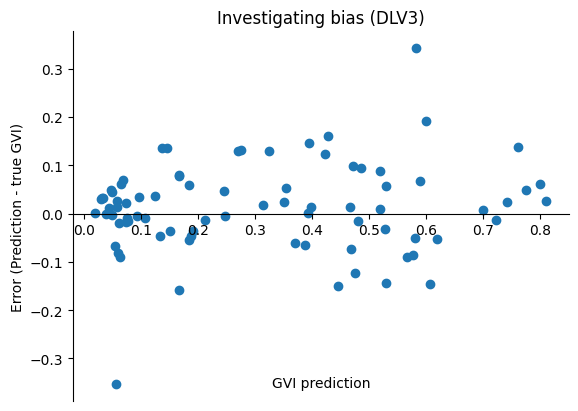

In [42]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ax.scatter(DLV3_prediction['pred'], DLV3_prediction['diff_with_sign'])

# Move the y-axis to x=0
ax.spines['bottom'].set_position(('data', 0))
# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("GVI prediction", labelpad=100)
ax.set_ylabel("Error (Prediction - true GVI)")
ax.set_title("Investigating bias (DLV3)")

In [21]:
DLV3_prediction.loc[DLV3_prediction['pred'] < DLV3_prediction['gt'], 'estimation'] = 'underestimation'
DLV3_prediction.loc[DLV3_prediction['pred'] == DLV3_prediction['gt'], 'estimation'] = 'accurate estimation'
DLV3_prediction.loc[DLV3_prediction['pred'] > DLV3_prediction['gt'], 'estimation'] = 'overestimation'

In [22]:
DLV3_prediction.estimation.value_counts()

overestimation     46
underestimation    34
Name: estimation, dtype: int64

In [23]:
grouped_df = pd.DataFrame(DLV3_prediction.groupby([bins, 'estimation']).size()).reset_index().rename(columns={0: 'count'})
grouped_df.pred = grouped_df.pred.astype(str)
grouped_df

,pred,estimation,count
0,"(0.0192, 0.218]",overestimation,19
1,"(0.0192, 0.218]",underestimation,19
2,"(0.218, 0.415]",overestimation,10
3,"(0.218, 0.415]",underestimation,3
4,"(0.415, 0.613]",overestimation,11
5,"(0.415, 0.613]",underestimation,10
6,"(0.613, 0.81]",overestimation,6
7,"(0.613, 0.81]",underestimation,2


Text(0.5, 1.0, 'Error analysis of GVI prediction predictions by bins (DeepLabV3+)')

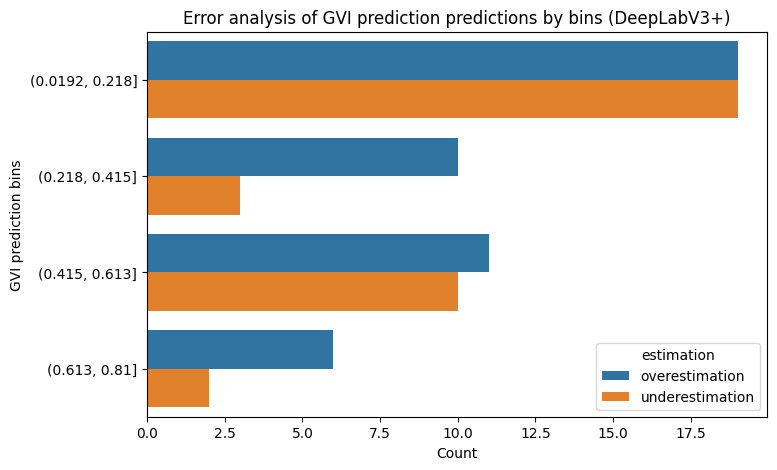

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have the grouped_df DataFrame with two levels of index
# grouped_df = ...

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
plt.show = sns.barplot( data=grouped_df, hue='estimation', x='count', y='pred', orient='h', dodge=True, ax=ax)

#ax.set_yticklabels(grouped_df[['pred']].astype(str))
ax.set_xlabel('Count')
ax.set_ylabel('GVI prediction bins')
ax.set_title('Error analysis of GVI prediction predictions by bins (DeepLabV3+)')


In [11]:
DLV3_prediction.estimation.value_counts()

overestimation     46
underestimation    34
Name: estimation, dtype: int64

In [9]:
#DLV3_prediction.to_csv("data/output_data/DLV3_test_evaluation.csv")